# AlphaZero - Implementing the Policy Network

Here I'll be working out how to implement the Policy network for AlphaZero. The idea here is to come up with a nice representation of the board position that will make the code easier to handle later.

## Initialise Game + Model

In [1]:
import chess
import chess.pgn

import numpy as np
import tensorflow as tf
import keras

import random
import collections
import itertools as it
from functools import reduce

Using TensorFlow backend.


In [2]:
# Board State Parameters
PROGRESS_COUNT = 0
TRANSPOSITION_COUNT = 0

# Hyperparameters
FILTERS = 256
NUM_BLOCKS = 20

# number of board layers (6 each for white + black plus 2 for board repetitions)
BOARD_PLANES = 14
# number of past board positions to include in features (default: 8 moves back)
REPETITION_COUNT = 8
# number of extra planes to describe the game state
# colour, total move count, p1 castling, p2 castling, no-progress count
FEATURE_PLANES = 7

BOARD_SHAPE = (8, 8)
INPUT_SHAPE = (BOARD_PLANES * REPETITION_COUNT + FEATURE_PLANES, *BOARD_SHAPE)

In [3]:
def get_layer_names():
    titlecase = lambda s: s[0].upper() + s[1:]

    board_layers = ["P1 " + titlecase(n) for n in chess.PIECE_NAMES[1:]] + \
    ["P2 " + titlecase(n) for n in chess.PIECE_NAMES[1:]] + \
    ["Repetition 1", "Repetition 2"]

    layer_names = [x[0] + " " + x[1] for x in it.product(["T" + str(i + 1) for i in range(8)], board_layers)]

    layer_names = layer_names + [titlecase(s) for s in ['colour', 'total move count', 'p1 A-Rook Can Castle', 'p1 B-Rook Can Castle', 'p2 A-Rook Can Castle', 'p2 B-Rook Can Castle', 'no-progress count']]

    return layer_names

layer_names = get_layer_names()

In [4]:
def featurise_board(board, PROGRESS_COUNT, TRANSPOSITION_COUNT, board_data = None):
    
    if type(board_data) != np.ndarray:
        board_data = np.zeros(shape = INPUT_SHAPE)

    def int_to_mask(squares):
        '''Takes a set of squares as an integer and returns an 8 x 8 matrix of 
           the marked squares'''
        # convert int to binary
        squares = np.binary_repr(squares, width = 64)
        # break int string into one-hot array
        squares = np.array([i for i in squares])
        # reshape into 8 by 8 matrix
        squares = squares.reshape(*BOARD_SHAPE)
        # flip along y axis (for some reason)
        squares = squares[:, ::-1]
        # change strings to ints before returning
        return squares.astype(np.int0)

    for i, piece_type in enumerate(it.product(chess.COLORS, chess.PIECE_TYPES)):
        color, piece = piece_type
        piece_location = board.pieces_mask(
            color = board.turn == color,    # True if p1 is white, False otherwise
            piece_type = piece)
        board_data[i, :, :] = int_to_mask(piece_location)

    # Add repetition count features
    if TRANSPOSITION_COUNT > 1:
        board_data[BOARD_PLANES - 2, :, :] = np.ones(BOARD_SHAPE)
    if TRANSPOSITION_COUNT > 2:
        board_data[BOARD_PLANES - 1, :, :] = np.ones(BOARD_SHAPE)

    ## Setting the constant layers:

    # Set the current players turn - place these at the bottom of the 1st index
    board_data[-FEATURE_PLANES, :, :] = np.full(BOARD_SHAPE, board.turn)

    # Set the total move count
    board_data[1 - FEATURE_PLANES, :, :] = np.full(BOARD_SHAPE, 
                                                   len(board.move_stack))

    # Set castling features
    rook_mask = board_data[chess.ROOK - 1, :, :] + \
                board_data[chess.ROOK - 1 + 6, :, :] 

    # Player 1:
    player_1 = board.turn
    # Rook on the A file can castle 
    board_data[2 - FEATURE_PLANES, :, :] = np.full(BOARD_SHAPE, 
                                                   rook_mask[player_1 * 7, 0])
    # Rook on the H file can castle 
    board_data[3 - FEATURE_PLANES, :, :] = np.full(BOARD_SHAPE, 
                                                   rook_mask[player_1 * 7, 7])

    # Player 2 castling:
    player_2 = not player_1
    # Rook on the A file can castle 
    board_data[4 - FEATURE_PLANES, :, :] = np.full(BOARD_SHAPE, 
                                                   rook_mask[player_2 * 7, 0])
    # Rook on the H file can castle 
    board_data[5 - FEATURE_PLANES, :, :] = np.full(BOARD_SHAPE, 
                                                   rook_mask[player_2 * 7, 7])

    # No progress count goes here:
    board_data[6 - FEATURE_PLANES, :, :] = np.full(BOARD_SHAPE, PROGRESS_COUNT)
    
    return board_data.reshape(1, *INPUT_SHAPE)

In [5]:
def get_current_time():
    '''Get the current time as a formatted string'''
    from datetime import datetime
    return datetime.strftime(datetime.now(), "%Y/%m/%d %H:%M:%S.%f")

def initialise_game():
    '''Initialise the game and board objects'''
    game = chess.pgn.Game()
    board = game.board()
    game.headers['Date'] = get_current_time()
    game.headers['Black'] = 'Random Agent'
    game.headers['White'] = 'Random Agent'
    
    board_data = featurise_board(board, PROGRESS_COUNT, TRANSPOSITION_COUNT)
    return game, board, board_data

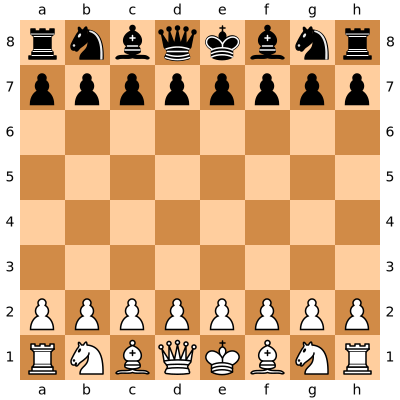

In [6]:
game, board, board_data = initialise_game()
board

In [7]:
from keras import layers

def convolutional_block(X, filters = FILTERS, kernel_size = (3, 3), 
                        activation = True):
    '''
    The convolutional block for the network. Performs convolution with a given 
    number of filters and kernel size.

    If an activation is given, then it will be applied to the output before the
    result is returned. If you want no activation function, then use 
    activation = None'''

    # run y through convolutional layer
    y = layers.Conv2D(
            filters = filters, 
            kernel_size = kernel_size,
            data_format = 'channels_first',
            padding='same')(X)

    # Apply batch normalisation
    y = tf.layers.batch_normalization(y)
    if activation:
        # Apply activation function
        y = tf.nn.relu(y)

    # return output tensor
    return y

def residual_tower(X, num_blocks = 10, filters = FILTERS):
    '''
    Constructs a residual tower consisting of a convolutional block, followed
    by a sequence of `num_blocks` residual blocks, each of with a fixed number 
    of filters.
    
    The residual tower output is passed to the policy + value heads for
    move prediction and board evaluation respectively'''
    
    def residual_block(X, activation = 'relu'):
        '''
        '''
        y = convolutional_block(X)
        y = convolutional_block(y, activation = None)
        X = convolutional_block(X, kernel_size = (1, 1), activation = None)
        y = tf.nn.relu(X + y)
        return y
    
    # Construct Residual Tower:
    y = convolutional_block(X)
    
    for i in range(num_blocks):
        y = residual_block(y)
    
    return y

def policy_head(y):
    '''
    '''
    y = convolutional_block(y, activation = True)
    y = layers.Flatten()(y)
    y = layers.Dense(units = 64 ** 2 + 4)(y)
    y = layers.Activation('softmax')(y)
    return y

def value_head(y):
    '''
    '''
    y = convolutional_block(y)
    y = layers.Flatten()(y)
    y = layers.Dense(units = FILTERS, activation = 'relu')(y)
    y = layers.Dense(units = 1, activation = 'tanh')(y)
    return y

In [8]:
# build the computational graph
sess = tf.Session()
X = tf.placeholder(dtype = tf.float32, shape = board_data.shape)
res_output = residual_tower(X, num_blocks = NUM_BLOCKS)
policy = policy_head(res_output)
value = value_head(res_output)
sess.run(tf.global_variables_initializer())

In [9]:
len(tf.get_default_graph().get_operations())

2722

In [10]:
policy = sess.run(policy, feed_dict = {X: board_data})

In [30]:
policy.shape

(1, 4100)

In [33]:
policy[0, np.argmax(policy)]

0.00024634998

In [25]:
policy_data = policy[0, :64 ** 2].reshape(8,8,8,8)
np.where(policy_data == np.max(policy_data))

(array([0], dtype=int64),
 array([2], dtype=int64),
 array([4], dtype=int64),
 array([6], dtype=int64))